## Why Low Accuracy with Logistics Regression

Logistics Regression use following equations, which \\(x_1, x_2, x_3, ..., x_n\\) are pixel values of a photo, \\(w_1, w_2, w_3, ..., w_n\\) are weight on each pixel \\(b\\) is the bias regardless of any pixel.

$$\begin{align*} 
z&=w_1x_1+w_2x_2+w_3x_3+...+w_nx_n+b \\
y&=\sigma(z)=\frac 1{1+e^{-z}}
\end{align*} $$

It's an extreme simple algorithm. We can think it as one layer **Neural Network** with just **ONE** neural in total. 
From pixel value \\(x_1, x_2, x_3, ..., x_n\\) to \\(z\\) is a linear map. While the world is not linear, so it can just catch part of the features. 

<img src="../images/Logistic-Regression.png" alt="Logistic-Regression" style="width: 400px;"/>

It is not bad to achieve 70% accuracy. 

## From Logistic Regression to 2 Layers Neural Network

If we extend a **Logistic Regression** a bit, adding one more layer in the algorithm, it shall be able to catch more features.

In the following graph, 

- \\(x_1, x_2, x_3, x_4\\) are input layer, through it is usually in total number of layers. in this case it has 4 input features.
- \\(a_1^{[1]}, a_2^{[1]}, a_3^{[1]}, a_3^{[1]}\\) are layer 1, in this case it has 4 features.
- \\(\hat y\\) are output layer, in this case it has only 1 output. 
<img src="../images/2Layers-NN.png" alt="2Layers-NN" style="width: 500px;"/>

## Forward Propagation

From literatures, here are **forward propagation** equations for the 2 layers neural network. It uses tanh activation function in this case.

$$\begin{align*} 
Z^1 &= W^1\cdot X + b^1 \\
[n_1, m] &\Leftarrow [n_1, n_x] \cdot  [n_x, m] + [n_1, 1]\\
A^1 &= tanh (Z^1)\\
Z^2 &= W^2\cdot Z^1 + b^2 \\
[n_y, m] &\Leftarrow [n_y, n_1] \cdot  [n_1, m] + [n_y, 1]\\
A^1 &= \sigma (Z^2)
\end{align*} $$

We can simply transfer the equation to Python code

In [1]:
import numpy as np

def forward_progagate(X, Y, W1, b1, W2, b2):
    Z1 = np.dot(W1, X) + b1                     # [n_1, m]   <= [n_1, n_x] . [n_x, m]
    A1 = np.tanh(Z1)                            # [n_1, m]  
    Z2 = np.dot(W2, A1) + b2                    # [n_y, m]   <= [n_y, n_1] . [n_1, m]
    A2 = 1.0 / (1.0 + np.exp(-Z2))              # [n_y, m]  

    return A1, A2

## Forward Propagation Dimensions

In the cat/none-cat classification problem, 

- \\(n_x=64*64*3\\), the input dimension, 
- \\(n_y = 1\\), the out dimension, only one value
- \\(n_1=10\\), if just pick the hidden layer size. This number will be adjusted later in the blog to test different accuracy result.


For all the variables used in the forward propagation have shape

|parameter|shape|shape value|
|:--------|:----|:----------|
| X       | [n_x, m]  | [12288, m]|
| A1/Z1   | [n_1, m]  | [10, m]
| Y/A2/Z2 | [n_y, m]  | [1, m]|
| W1      | [n_1, n_x]| [10,12288]|
| b1      | [n_1, 1]  | [10, 1] |
| W2      | [n_y, n_1]| [1,10]|
| b2      | [n_y, 1]  | [1, 1]|

## Total Number of Parameters

We can use following equation to calculate totally number of parameters. If we take \\(n_1=10\\), then there are totally have 122901. In which the first layer has 122880 features, due to the input feature is large

$$\begin{align*} 
n_1*n_x\ +\ n_1 * 1\ +\ n_y * n_1\ +\ n_y * 1 
&= 10 * 12288 \ +\ 10 * 1\ +\ 1 * 10\ +\ 1 * 1 \\
&= 122901
\end{align*} $$

## Backward Propagation

From the previous blog, we could get the following equation if the last layer using sigmoid as activation function.

$$\begin{align*} 
dZ_2 &= A2 - Y \\
dW_2 &=\frac{1}{m}(A2 - Y)\cdot X^T\\
[1, dim] &\Leftarrow [1, m] \cdot  [dim, m]^T \\
db_2&=\frac{1}{m}\sum_{i=1}^m(A-Y) \\
\\
g_1(z) &=tanh(z) \\
g_1'(z) &= 1-tanh(z)^2 = 1 - A_1^2\\
\\
dZ_1 &= W_2^T \cdot dZ2 * g_1'(Z_1) = W_2^T \cdot dZ2 * (1 - A_1^2) \\
dW_1 &= dZ_1 . X^T \\
db_1 &= \frac{1}{m}\sum_{i=1}^mdZ_1
\end{align*} $$

We can implement the backward propations with following python code

In [41]:
import numpy as np
def backward_propagate(X, Y, A1, A2, W1, b1, W2, b2):
    """
    X: [n_x, m]      train data set
    Y: [n_y,  m]     label data
    W1:[n_1, n_x]    weight for the first layer
    b1:[n_1, 1]      bias for the first layer
    W2:[n_y, n_1]    weight for the second layer
    b1:[n_y, 1]      bias for the first layer
    returns:         dW1, db1, dW2, db2
    """
    n_x, m = X.shape
    
    dZ2 = A2 - Y                                   # [n_y, m] 
    dW2 = np.dot(dZ2, A1.T) / m                    # [n_y, n_1] <= [n_y, m] .   [n_1, m].T
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m   # [n_y, 1]   <= [n_y, m]
    
    dgZ1 = 1 - np.power(A1, 2)                     # [n_1, m]
    dZ1  = np.multiply(np.dot(W2.T, dZ2), dgZ1)    # [n_1, m]   <= [n_y, n_1].T . [n_y, m]
    dW1  = np.dot(dZ1, X.T) / m                    # [n_1, n_x] <= [n_1, m]     . [n_x, m].T
    db1  = np.sum(dZ1, axis=1, keepdims=True) / m  # [n1, 1]    <= [n_1, m]
    
    return dW1, db1, dW2, db2

## 2 Layers Neural Model

And the whole training model can be implemented like this

In [42]:
def nn_2_layers(X, Y, n_1, num_iterations=10, learning_rate=0.01, 
                early_stop_cost=0., msg_interval=1, print_interval=100):
    """
    X: [n_x, m]      train data set
    Y: [n_y, m]      n_y=1 in this case
    n_1:             first hidden layer dimension
    num_iterations:  number iterations
    learning_rate:   learning rate, alpha
    early_stop_cost: early stop cost, if the cost small than this number, the train will stop
    returns:         W1, b1, W2, b2, A, i (A, is the output, i is the number of iterations)
    """
    n_x, m = X.shape
    n_y = 1
    
    W1 = np.random.randn(n_1, n_x) * 0.01
    b1 = np.zeros([n_1, 1])
    W2 = np.random.randn(n_y, n_1) * 0.01
    b2 = np.zeros([n_y, 1])
    print("init weights", W1[0][0], W2[0][0])
        
    costs = []
    msgs = []
    
    for i in range(num_iterations):
        A1, A2 = forward_progagate(X, Y, W1, b1, W2, b2)
        dW1, db1, dW2, db2 = backward_propagate(X, Y, A1, A2, W1, b1, W2, b2)
        
        W1 = W1 - learning_rate * dW1
        b1 = b1 - learning_rate * db1
        W2 = W2 - learning_rate * dW2
        b2 = b2 - learning_rate * db2
        
        cost = np.sum(-(np.dot(Y, np.log(A2.T)) + np.dot(1-Y, np.log(1-A2.T)))) / m
        cost = np.squeeze(cost)
        costs.append(cost)
        
        if cost < early_stop_cost:
            break

        if i % msg_interval == 0:
            train_predict, train_accuracy, test_predict, test_accuracy = cat_utils.accuracy_2_layers(
                W1, b1, W2, b2, test_set_x, test_set_y, A2, train_set_y)
            msg = (i, n_1, learning_rate, cost, train_accuracy, test_accuracy)
            msgs.append(msg)
            
            if i % print_interval == 0:
                print(i, msg)
                if 'debug' in globals() and debug:  
                    print(i, " derivitive", dW1[0][0], dW2[0][0], db1[0][0], db2[0][0])
                    print(i, " weights", W1[0][0], W2[0][0])


    print(i, msgs[-1])
    
    return W1, b1, W2, b2, A2, msgs, costs

## Load the Cata Dataset

In [43]:
import cat_utils
train_set_x, train_set_y, test_set_x, test_set_y, classes = cat_utils.load_normalized_dataset()

## Train with 2 layer neural network

In [44]:
import time

def train(params):
    n_1 = params["n_1"]
    num_iterations = params["num_iterations"]
    learning_rate = params["learning_rate"]
    early_stop_cost = params["early_stop_cost"]

    start = time.time()
    np.random.seed(1)     # set seed, so that the result is comparable 
    W1, b1, W2, b2, A2, msgs, costs = nn_2_layers(train_set_x, train_set_y, n_1, 
                                    num_iterations, learning_rate, early_stop_cost)
    i, n_1, learning_rate, cost, train_accuracy, test_accuracy = msgs[-1]
    
    md_row_format = "|{0}|{1}|{2}|{3}|{4}|{5}|{6}|"
    md_row = md_row_format.format(n_1, learning_rate, cost, i, time.time() - start, train_accuracy, test_accuracy)
    
    return md_row, W1, b1, W2, b2, msgs, costs

In [48]:
from IPython.display import display, Markdown
md_rows = ["|n_1|learning_rate|stop_cost|iterations|training_time|train_accuracy|test_accuracy|",
            "|:--|:------------|:--------|:---------|:------------|:-------------|:------------|"]
debug=False
param = {"n_1": 100, "num_iterations": 801, "learning_rate": 0.03, "early_stop_cost": 0.05}
md_row, W1, b1, W2, b2, msgs, costs = train(param)
md_rows.append(md_row)
display(Markdown("\n".join(md_rows)))

init weights 0.01624345363663242 0.007582108466210078
0 (0, 100, 0.03, 0.6876763164803181, 0.6220095693779905, 0.34)
100 (100, 100, 0.03, 0.5136914203235036, 0.7368421052631579, 0.56)
200 (200, 100, 0.03, 0.4402648719037226, 0.7799043062200957, 0.6)
300 (300, 100, 0.03, 0.6875212497724041, 0.6842105263157895, 0.8)
400 (400, 100, 0.03, 0.28232346343875814, 0.8803827751196173, 0.8)
500 (500, 100, 0.03, 0.17913990779918323, 0.9665071770334929, 0.78)
600 (600, 100, 0.03, 0.098001059685213, 0.9904306220095693, 0.76)
700 (700, 100, 0.03, 0.3674896956572515, 0.7894736842105263, 0.36)
786 (785, 100, 0.03, 0.05010942358258495, 1.0, 0.76)


|n_1|learning_rate|stop_cost|iterations|training_time|train_accuracy|test_accuracy|
|:--|:------------|:--------|:---------|:------------|:-------------|:------------|
|100|0.03|0.05010942358258495|785|17.712958097457886|1.0|0.76|

In [22]:
costs[-1]

0.15725338524627208

## Accuracy for Train and Test Data Set

Accuracy for train set is used to measure how good the model is, for the data it has seen.

Accuracy for train set is used to measure how good the model is, for the data it has **NOT** seen. 
In other words, it is used to measure how general the model is.

With the model we get, we can write followning code to get the accuracy

train accuracy 0.9952153110047847
test accuracy 0.8


## Results with Different Hyper Parameters

Choose different hyper parameters will get different result. 

Here are some results from variance configurations. The best test accuracy got is 80%, better then 70% with logistics regression. From the test, we also see that the accuracy is not always higher when use more neurals.

|n_1|learning rate | stop cost | # iterations| training time | train set accuracy | test accuracy |
|:----|:----|:----------|
| 100 |0.0003 | 0.1  | 2000  |  8 |1 | 0.78 |
| 100 |0.0003 | 0.002  | 2000  |  34 |1 | 0.76 |
| 500 |0.0003 | 0.1      | 471  |  60 |0.9856 | 0.78 |
| 500 |0.0003 | 0.00187  | 2000  |  260 |1 | 0.76 |
| 1000 |0.0003 | 0.1  | 480  |  128 |0.98 | 0.8 |
| 1000 |0.0003 | 0.0017  | 2000  |  530 |1 | 0.74 |
| 2000 |0.0003 | 0.1  | 2000  |  530 |1 | 0.74 |

## Show Wrong Classficiations

wrong predict on train sample  92  to  [0] which should be [1]


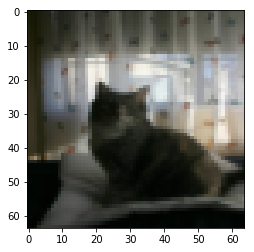

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
wrong_index = np.argmax(train_predict != train_set_y)
print("wrong predict on train sample ", wrong_index, " to ", train_predict[:, wrong_index], 
      "which should be", train_set_y[:, wrong_index])
plt.imshow(train_set_x_orig[wrong_index])


wrong predict on test sample  5  to  [1] which should be [0]


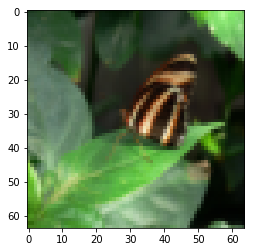

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
wrong_index = np.argmax(test_predict != test_set_y)
print("wrong predict on test sample ", wrong_index, " to ", test_predict[:, wrong_index], 
      "which should be", test_set_y[:, wrong_index])
plt.imshow(test_set_x_orig[wrong_index])



## Goes to More Layers

In the code written before, it is fixed to 2 layers. 

With a little bit extension, it will be able to extend to multiple layers.

In [23]:
def initilize_parameters(X, Y, hidden_layer_dims, activations):
    """
    layer_dims: [n_x, n_1, n_2, ..., n_y]
    activations: [not_used, relu, relu, ..., sigmoid]
    """
        
    n_x, m = X.shape
    n_y, _ = Y.shape

    # And input layer, and output layer
    layer_dims = [n_x] + hidden_layer_dims + [n_y] 
    L = len(layer_dims) - 1
    
    W = [l for l in range(L + 1)] # W[0] - W[L], W[0] is not used
    b = [l for l in range(L + 1)] # b[0] - b[L], b[0] is not used
    
    # Initialize parameters
    for l in range(1, L + 1): # 1 - L
        if activations[l] == "relu":        
            norm = np.sqrt(2.0 / layer_dims[l-1]) # He Initialization, He et al., 2015
        elif activations[l] == "tanh":
            norm = 0.01
        elif activations[l] == "sigmoid":
            norm = 0.01
        else:
            norm = 1
        if 'debug' in globals() and debug:            
            print("layer", l, "[", layer_dims[l], layer_dims[l-1], "]", activations[l], norm)
            
        W[l] = np.random.randn(layer_dims[l], layer_dims[l-1]) * norm # (n[l], n[l-1])
        b[l] = np.zeros((layer_dims[l], 1))


    # print one param for debug
    if 'debug' in globals() and debug:
        print("init weights", W[1][0][0], W[2][0][0])
    
    return W, b

In [32]:
debug=True

In [33]:
def forward_propagate_n_layers(X, W, b, activations, iter_i=-1):
    """
    X: Input
    W: [not_used, W1, W2, ..., WL]
    b: [not_used, b1, b2, ..., bL]
    activations: [not_used, relu, relu, ..., sigmoid]    
    """
    L = len(W) - 1
    
    Z  = [l for l in range(L+1)]
    A  = [l for l in range(L+1)]
    
    A[0] = X
    
    for l in range(1, L+1):
        Z[l] = np.dot(W[l], A[l - 1]) + b[l] # (n[l], m) <= (n[l], n[l-1]) . (n[l-1], m) + (n[l], 1)
        
        if activations[l] == "relu":        
            A[l] = np.max(0, Z[l])
        elif activations[l] == "tanh":
            A[l] = np.tanh(Z[l])
        elif activations[l] == "sigmoid":
            A[l] = 1.0 / (1.0 + np.exp(-Z[l]))
        else:
            raise Exception("activation " + activations[l] + "not supported")
            
        if iter_i == 0 and 'debug' in globals() and debug:
            shape_info = "Z[l] = np.dot(W[l], A[l - 1]) + b[l] {shape1} <= {shape2} . {shape3} + {shape4}".format(
                shape1=Z[l].shape, shape2=W[l].shape, shape3=A[l-1].shape, shape4=b[l].shape)
            print(l, activations[l], shape_info)
            
    return A, Z

In [54]:
def backward_propagate_n_layers(X, A, Y, W, b, activations, iter_i=-1, lambd=0):
    n_x, m = X.shape
    L = len(W) - 1

    dA = [l for l in range(L + 1)] # index 0 not used
    dZ = [l for l in range(L + 1)]
    dW = [l for l in range(L + 1)]
    db = [l for l in range(L + 1)]

    
    # Backward propagation for the last layer
    if activations[L] == "sigmoid":
        dA[L] = -(np.divide(Y, A[L]) - np.divide(1 - Y, 1 - A[L]))
        # The way to calculate dZL is different than other layers, due to different activation function
        dZ[L] = A[L] - Y
    else:
        raise Exception("activation " + activations[L] + "not supported")
        
    dW[L] = np.dot(dZ[L], A[L-1].T) / m  + lambd * W[L] / m
    db[L] = np.sum(dZ[L], axis=1, keepdims=True) / m

    # Backward propagation for other layers
    for l in reversed(range(1, L)):
        if iter_i == 0 and 'debug' in globals() and debug:
            print(l, "W[l].shape", W[l].shape, "dZ[l+1].shape", dZ[l+1])

        if activations[l] == "tanh":
            dgZl = 1 - np.power(A[l], 2)
            dZ[l] = np.multiply(np.dot(W[l+1].T, dZ[l+1]), dgZl)
#         elif activations[l] == "relu":
        else:
            raise Exception("activation " + activations[L] + "not supported")
            
        dW[l] = np.dot(dZ[l], A[l-1].T) / m + lambd * W[l] / m
        db[l] = np.sum(dZ[l], axis=1, keepdims=True) / m
        
    return dW, db

In [55]:
def calculate_cost(W, AL, Y, lambd=0):
    n_y, m = Y.shape
        
    # calculate cost
    
    cross_entropy_cost = -np.sum((np.dot(Y, np.log(AL.T)) + np.dot(1-Y, np.log(1-AL.T)))) / m
    
    regulation = 0
    if lambd > 0:
        for l in range(1, len(W)):
            regulation += np.sum(W[l])
            
    return np.squeeze(cross_entropy_cost) + regulation / m

In [68]:
def neural_network_n_layers(X, Y, test_set_x, test_set_y, hidden_layer_dims, activations, 
                            num_iterations=10, learning_rate=0.01, early_stop_cost=0., lambd=0,
                            msg_interval=1, print_interval=100):
    """
    X:                 train input
    Y:                 train labels
    hidden_layer_dims: all hidden layer units
    """
#     n_x, m = X.shape
#     n_y, _ = Y.shape

    # And input layer, and output layer
    L = len(hidden_layer_dims) + 1

    activations.insert(0, "not_used")
        
    W, b = initilize_parameters(X, Y, hidden_layer_dims, activations)

    
    costs = []
    msgs = []
    for i in range(num_iterations):
        A, Z = forward_propagate_n_layers(X, W, b, activations)
        dW, db = backward_propagate_n_layers(X, A, Y, W, b, activations)
            
        # update parameters
        for l in range(1, L + 1):
            W[l] = W[l] - learning_rate * dW[l]
            b[l] = b[l] - learning_rate * db[l]
            
        if i == 0 and 'debug' in globals() and debug:        
            print("dW[1][0][0], dW[2][0][0]", dW[1][0][0], dW[2][0][0])
            print("db[1][0][0], db[2][0][0]", db[1][0][0], db[2][0][0])
            print(" W[1][0][0],  W[2][0][0]",  W[1][0][0],  W[2][0][0])
            
        cost = calculate_cost(W, A[L], Y, lambd)
        costs.append(cost)
        
        if cost < early_stop_cost:
            break

        if i % msg_interval == 0:
            train_predict, train_accuracy, test_predict, test_accuracy = cat_utils.accuracy_n_layers(
                W, b, test_set_x, test_set_y, A[-1], train_set_y)
            msg = (i, hidden_layer_dims, learning_rate, cost, train_accuracy, test_accuracy)
            msgs.append(msg)
            
            if i % print_interval == 0:
                print(msg)
                if 'debug' in globals() and debug:  
                    print(i, " weights", W[1][0][0], W[2][0][0])
            
    print(msgs[-1])
    
    return W, b, A, msgs, costs

## Sanity Check for the Multi Layer Code

Run training with same configuration to see if it has same result

In [57]:
import time
import cat_utils
import numpy as np

train_set_x, train_set_y, test_set_x, test_set_y, classes = cat_utils.load_normalized_dataset()
start = time.time()

np.random.seed(1)
W, b, A, msgs, costs = neural_network_n_layers(train_set_x, train_set_y, test_set_x, test_set_y, 
                                               hidden_layer_dims=[100],
                                activations=["tanh", "sigmoid"],
                                num_iterations = 801, learning_rate = 0.03, early_stop_cost=0.1, lambd=0.1)

print("total training time", time.time() - start)

0 (0, 100, 0.03, 0.7058834921042767, 0.6220095693779905, 0.34)
100 (100, 100, 0.03, 0.49224530410620004, 0.7368421052631579, 0.56)
200 (200, 100, 0.03, 0.42895316029856206, 0.7799043062200957, 0.6)
300 (300, 100, 0.03, 0.6426557409354395, 0.6842105263157895, 0.8)
400 (400, 100, 0.03, 0.2282545359417549, 0.8803827751196173, 0.8)
500 (500, 100, 0.03, 0.19079278675607342, 0.9665071770334929, 0.78)
(560, 100, 0.03, 0.10251211743083408, 0.9808612440191388, 0.78)
total training time 13.550458908081055


In [65]:
def train_n_layers(params):
    dims = params["dims"]
    activations = params["activations"]
    num_iterations = params["num_iterations"]
    learning_rate = params["learning_rate"]
    early_stop_cost = params["early_stop_cost"]

    start = time.time()
    np.random.seed(1)     # set seed, so that the result is comparable 
    W, b, A, msgs, costs = neural_network_n_layers(
        train_set_x, train_set_y, test_set_x, test_set_y, 
        hidden_layer_dims=dims,
        activations=activations,
        num_iterations = num_iterations, learning_rate = learning_rate, early_stop_cost=early_stop_cost, lambd=0.1)
    
    return W, b, msgs, costs

In [66]:
param = {"dims": [100], "activations": ["tanh", "sigmoid"], "num_iterations": 801, "learning_rate": 0.03, "early_stop_cost": 0.05}
result = train_n_layers(param)

0 (0, 100, 0.03, 0.7058834921042767, 0.6220095693779905, 0.34)
100 (100, 100, 0.03, 0.49224530410620004, 0.7368421052631579, 0.56)
200 (200, 100, 0.03, 0.42895316029856206, 0.7799043062200957, 0.6)
300 (300, 100, 0.03, 0.6426557409354395, 0.6842105263157895, 0.8)
400 (400, 100, 0.03, 0.2282545359417549, 0.8803827751196173, 0.8)
500 (500, 100, 0.03, 0.19079278675607342, 0.9665071770334929, 0.78)
600 (600, 100, 0.03, 0.0682916163482325, 0.9904306220095693, 0.76)
(692, 100, 0.03, 0.06150610384970157, 0.9904306220095693, 0.78)


In [67]:
len(result)

4

In [79]:
from IPython.display import display, Markdown
md_rows = ["|dims|learning_rate|stop_cost|iterations|training_time|train_accuracy|test_accuracy|",
            "|:--|:------------|:--------|:---------|:------------|:-------------|:------------|"]
debug=False
param = {"dims": [100], "activations": ["tanh", "sigmoid"], "num_iterations": 801, "learning_rate": 0.03, "early_stop_cost": 0.05}

W, b, msgs, costs = train_n_layers(param)
md_row = "|" + "|".join([str(m) for m in msgs[-1]]) + "|"
md_rows.append(md_row)
display(Markdown("\n".join(md_rows)))

(0, [100], 0.03, 0.7058834921042767, 0.6220095693779905, 0.34)
(100, [100], 0.03, 0.49224530410620004, 0.7368421052631579, 0.56)
(200, [100], 0.03, 0.42895316029856206, 0.7799043062200957, 0.6)
(300, [100], 0.03, 0.6426557409354395, 0.6842105263157895, 0.8)
(400, [100], 0.03, 0.2282545359417549, 0.8803827751196173, 0.8)
(500, [100], 0.03, 0.19079278675607342, 0.9665071770334929, 0.78)
(600, [100], 0.03, 0.0682916163482325, 0.9904306220095693, 0.76)
(692, [100], 0.03, 0.06150610384970157, 0.9904306220095693, 0.78)


|dims|learning_rate|stop_cost|iterations|training_time|train_accuracy|test_accuracy|
|:--|:------------|:--------|:---------|:------------|:-------------|:------------|
|692|[100]|0.03|0.06150610384970157|0.9904306220095693|0.78|

## Train with Multiple Layers

In [86]:
import time
start = time.time()

np.random.seed(1)
W, b, A, i = neural_network(train_set_x, train_set_y, hidden_layer_dims=[4000, 1000, 100], 
                                num_iterations = 2001, learning_rate = 0.0003, early_stop_cost=0.01)

print("total training time", time.time() - start)

1 [12288, 4000, 1000, 100, 1]
4000 12288
2 [12288, 4000, 1000, 100, 1]
1000 4000
3 [12288, 4000, 1000, 100, 1]
100 1000
4 [12288, 4000, 1000, 100, 1]
1 100
1 Z[l] = np.dot(W[l], A[l - 1]) + b[l] (4000, 209) <= (4000, 12288) . (12288, 209) + (4000, 1)
2 Z[l] = np.dot(W[l], A[l - 1]) + b[l] (1000, 209) <= (1000, 4000) . (4000, 209) + (1000, 1)
3 Z[l] = np.dot(W[l], A[l - 1]) + b[l] (100, 209) <= (100, 1000) . (1000, 209) + (100, 1)
0 0.6928992495661196
100 0.5531052915033404
200 0.5206654073621815
300 0.42194685494351186
400 0.38357103780215956
500 0.22895489861599505
600 0.17356639173122615
700 0.3672409324802559
800 0.19109577773245418
900 0.08392015545348908
1000 0.03287598121733326
1052 0.009850211680890241
total training time 1117.511100769043


## Check Accuracy with Multi Layer Neural Network

In [77]:
def accuracy_n_layers(W, b, A):
    train_predict = np.where(A >= 0.5, 1, 0)
    train_accuracy = np.sum(train_predict == train_set_y) / train_set_y.shape[1]
    print("train accuracy", train_accuracy)

    L = len(W) - 1
    
    Z  = [l for l in range(L + 1)]
    A  = [l for l in range(L + 1)]
    A[0] = test_set_x
    
    for l in range(1, L):
        Z[l] = np.dot(W[l], A[l-1]) + b[l]      # [n_1, m] <= [n_1, n_x] . [n_x, m]
        A[l] = np.tanh(Z[l])                    # [n_1, m]  
        
    ZL = np.dot(W[L], A[L-1]) + b[L]            # [n_y, m] <= [n_y, n_1] . [n_1, m]
    AL = 1.0 / (1.0 + np.exp(-ZL))              # [n_y, m]
    
    test_predict = np.where(AL >= 0.5, 1, 0)    
    test_accuracy = np.sum(test_predict == test_set_y) / test_set_y.shape[1]
    print("test accuracy", test_accuracy)

    return train_predict, train_accuracy, test_predict, test_accuracy

In [61]:
train_predict, train_accuracy, test_predict, test_accuracy = cat_utils.accuracy_n_layers(
    W, b, test_set_x, test_set_y, A[-1], train_set_y)
print("train_accuracy", train_accuracy)
print("test_accuracy ", test_accuracy)

train_accuracy 0.9952153110047847
test_accuracy  0.76


## Test Accuracy with Different Configuration

|dims|learning rate | stop cost | # iterations| training time | train set accuracy | test accuracy |
|:----|:----|:----------|
| [100] |0.0003 | 0.1  | 2000  |  8 |1 | 0.78 |
| [100] |0.0003 | 0.002  | 2000  |  34 |1 | 0.76 |
| [500] |0.0003 | 0.1      | 471  |  60 |0.9856 | 0.78 |
| [500] |0.0003 | 0.00187  | 2000  |  260 |1 | 0.76 |
| [1000] |0.0003 | 0.1  | 480  |  128 |0.98 | 0.8 |
| [1000] |0.0003 | 0.0017  | 2000  |  530 |1 | 0.74 |
| [2000] |0.0003 | 0.1  | 2000  |  530 |1 | 0.74 |
| [1000,100] |0.0003 | 0.1  | 2000  |  530 |0.9665 | 0.8 |
| [1000,100] |0.0003 | 0.00057  | 2000  |  568 |1 | 0.76 |
| [2000,100, 10] |0.0003 | 0.00057  | 2000  |  1040 |1 | 0.76 |
| [4000, 1000, 100] |0.0003 | 0.00057  | 2000  |  1040 |1 | 0.78 |
